In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda"

In [2]:
model = torchvision.models.vgg16(pretrained=True)
model.eval()
model = model.to(device)
#0-3 conv1 5-8 conv2 10-15 conv3 17-22 conv4 24-29 conv5 
conv1_1 = nn.Sequential(*list(model.features)[0:2])
conv2_1 = nn.Sequential(*list(model.features)[2:7])
conv3_1 = nn.Sequential(*list(model.features)[7:12])
conv4_1 = nn.Sequential(*list(model.features)[12:19])
conv4_2 = nn.Sequential(*list(model.features)[19:21])
conv5_1 = nn.Sequential(*list(model.features)[21:26])
print(conv5_1)
#VGGを特徴を抜き出したい6つに分割する

Sequential(
  (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
)


In [3]:
preprocess = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
#前処理はTensorにするのみ

torch.Size([3, 599, 470])


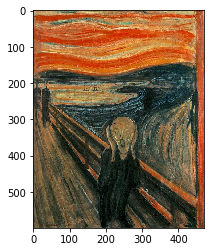

In [4]:
#style_img = preprocess(Image.open("../text19/img/night-style.jpg"))
style_img = preprocess(Image.open("../text19/img/scream-style.jpg"))
print(style_img.shape)
plt.imshow(style_img.numpy().transpose(1,2,0))
plt.show()
style_img = style_img.unsqueeze_(0)
style_img = style_img.to(device)
#スタイル画像の読み込み (1,C,H,W)の形に変形しておく

torch.Size([3, 640, 427])


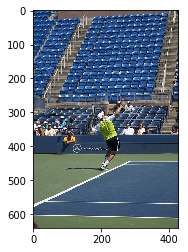

In [5]:

content_img = preprocess(Image.open("/export/data/dataset/COCO/train2014/COCO_train2014_000000321991.jpg"))
print(content_img.shape)
plt.imshow(content_img.numpy().transpose(1,2,0))
plt.show()
content_img = content_img.unsqueeze_(0)
content_img = content_img.to(device)

#コンテンツ画像の読み込み (1,C,H,W)の形に変形しておく

In [6]:
#グラム行列の計算
#(1,C,H,W)の特徴マップを(C,H+W)に変形してから転置したものと内積を取ることで
#(C,C)のグラム行列になる
#チャネル間に相関が強いほど大きい値になる
def gram(feature):
    c = feature.shape[1]
    feature = feature.view(c,-1)
    ret = feature.matmul(feature.T)
    return ret
#style lossはスタイル画像の特徴マップのグラム行列と生成画像の特徴マップのグラム行列の
#2乗和
def calc_styleloss(x_convn, style_convn):
    size = x_convn.shape[2]*x_convn.shape[3]
    c = x_convn.shape[1]
    return torch.sum((gram(x_convn)-gram(style_convn))**2)#/(4*c**2*size**2)
#画像を下に1ピクセルずらしたものと画像の差、画像を右に1ピクセルずらしたものと画像の差に対して
#lossを加えることで滑らかさを考慮する
def calc_total_variation_loss(x):
    a = x[:,:,:-1,:-1] - x[:,:,1:,:-1]
    b = x[:,:,:-1,:-1] - x[:,:,:-1,1:]
    return torch.sum((a**2 + b**2)**1.25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


itr: 99
content loss: 5196890.000000
style loss: 1585013632.000000
total variant loss: 16847.244141


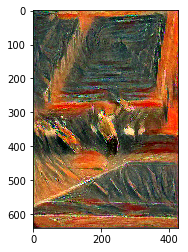

In [8]:
style_conv1_1 = conv1_1(style_img).detach()
style_conv2_1 = conv2_1(style_conv1_1).detach()
style_conv3_1 = conv3_1(style_conv2_1).detach()
style_conv4_1 = conv4_1(style_conv3_1).detach()
style_conv5_1 = conv5_1(conv4_2(style_conv4_1)).detach()
#style画像のそれぞれの層の特徴マップを取る
content_conv4_2 = conv4_2(conv4_1(conv3_1(conv2_1(conv1_1(content_img))))).detach()
#content画像のconv4_2層における特徴マップを取る
x = content_img.clone()
#x = torch.rand_like(content_img).to(device)
x.requires_grad = True
optim = opt.LBFGS(params=[x],lr=1)
#optimizerはLBFGSを用い、生成画像を更新する
for itr in range(100):
    def closure():
        global l_content,l_style,l_total_v
        x_conv1_1 = conv1_1(x)
        x_conv2_1 = conv2_1(x_conv1_1)
        x_conv3_1 = conv3_1(x_conv2_1)
        x_conv4_1 = conv4_1(x_conv3_1)
        x_conv4_2 = conv4_2(x_conv4_1)
        x_conv5_1 = conv5_1(x_conv4_2)
        #生成画像のそれぞれの層での特徴マップを取る
        
        #x_conv4_2 = conv4_2(conv4_1(conv3_1(conv2_1(conv1_1(x)))))
        
        l_content = torch.sum((x_conv4_2 - content_conv4_2)**2)/2
        #content lossはconv4_2層のL1距離
        #print(x_conv4_2.shape)
        #print(content_conv4_2.shape)
        l_s = []
        l_s.append(calc_styleloss(x_conv1_1, style_conv1_1))
        l_s.append(calc_styleloss(x_conv2_1, style_conv2_1))
        l_s.append(calc_styleloss(x_conv3_1, style_conv3_1))
        l_s.append(calc_styleloss(x_conv4_1, style_conv4_1))
        l_s.append(calc_styleloss(x_conv5_1, style_conv5_1))
        #それぞれの層のstyle画像と生成画像のstyle lossを計算
        w_s = [1,1,1,1,1]
        l_style = 0
        for w,l in zip(w_s, l_s):
            l_style += w*l
            #重みづけしてsum
        l_total_v = calc_total_variation_loss(x)
        #total variation loss
        loss =  l_content*0.025 + l_style + l_total_v*1e-4
        optim.zero_grad()
        loss.backward()
        return loss
    optim.step(closure)
    #重みの更新
    if itr % 10 == 9:
        display.clear_output()
        print("itr: %d"%itr)
        print("content loss: %f"%l_content)
        print("style loss: %f"%l_style)
        print("total variant loss: %f"%l_total_v)
        plt.imshow(x.detach().cpu().numpy().squeeze(0).transpose(1,2,0))
        plt.show()


なぜかstyle lossの4*C**2**HW**2で割ることをしないほうがうまくいったが原因がよくわからなかった。
最初はノイズからの生成を試みたがうまくcontentが埋め込まれなかった。

### 参考文献
Neural Style Transfer: Prismaの背景技術を解説する https://elix-tech.github.io/ja/2016/08/22/art.html

メディア情報学実験 画像実験3-2